# Bad Actors

Users who claim to be both Republican and Democrat

In [10]:
import re
import glob
import bz2
import lzma
import json
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser
from json import JSONDecodeError
from datetime import datetime
from collections import *

### Load in All Political User Data From Comments

Data is in the following format

```json
{
    "username1": [('democrat', '11-12-18'), ('republican', '11-15-18')]
}
```

In [11]:
in_file = '/shared/0/projects/reddit-political-affiliation/data/bad-actors/politics.json'

with open(in_file) as json_file:
    user_politics = json.load(json_file)
    
len(user_politics)

198037

### Remove Bot Accounts

In [12]:
# Remove known bot accounts + [deleted]\
fname = '/shared/0/projects/prosocial/known-bots.tsv'
bots = ['[deleted]']

with open(fname, 'rt') as f:
    lines = f.readlines()
    
    for line in lines:
        bots.append(line.split('\t')[1])

print("Known bots: %d" % len(bots))

user_politics_cleaned = {}

for user, political_data in user_politics.items():
    if user not in bots:
        # Sort user politics by date
        political_data.sort(key = lambda x: str(x[1]))
        user_politics_cleaned[user] = political_data
        
        
print("Total political users: %d" % len(user_politics_cleaned))

Known bots: 394
Total political users: 198036


### Number of Bad Actors w/o Time Constraint

In [21]:
bad_actors = {}
for user, political_data in user_politics_cleaned.items():
    politics = set()
    for (political_party, created_utc) in political_data:
        politics.add(political_party)
    if len(politics) > 1:
        bad_actors[user] = political_data
        
len(bad_actors)

20913

### Number of Bad Actors w/ Time Constraint

In [45]:
TIME_CONSTRAINT_DAYS = 30
bad_actors_constrained = {}


def ts_day_diff(ts_1, ts_2):
    d1, d2 = datetime.utcfromtimestamp(int(ts_1)), datetime.utcfromtimestamp(int(ts_2))
    delta = d1 - d2
    return abs(delta.days)

# Not efficient but hey it works
for user, political_data in bad_actors.items():
    democrat_timestamps = []
    for (political_party, created_utc) in political_data:
        if political_party.lower() == 'democrat':
            democrat_timestamps.append(created_utc)
            
    for (political_party, created_utc) in political_data:
        if political_party.lower() == 'republican':
            for ts in democrat_timestamps:
                if ts_day_diff(ts, created_utc) < TIME_CONSTRAINT_DAYS:
                    bad_actors_constrained[user] = political_data
                    
len(bad_actors_constrained)

7062

### Save to TSV

In [33]:
out_file = '/shared/0/projects/reddit-political-affiliation/data/bad-actors/bad_actors.json'

with open(out_file, 'w') as f:
    json.dump(bad_actors, f)

### Plot Political Users Over Time

In [16]:
year_month_counts = Counter()

for user, political_data in user_politics_cleaned.items():
    # Grab their 1st political post year month
    first_pol_post_ts = int(political_data[0][1])
    first_post_date = datetime.fromtimestamp(first_pol_post_ts)
    year_month = str(first_post_date.year) + '-' + str(first_post_date.month)
    year_month_counts[str(year_month)] += 1

# Convert to DF for seaborn
rows = []
for year_month, count in dict(year_month_counts).items():
    row = {'Year Month': parser.parse(year_month), 'Count': int(count)}
    rows.append(row)
    
df_time = pd.DataFrame(rows)
df_time

,Year Month,Count
0,2016-11-28,7298
1,2019-08-28,6031
2,2019-06-28,6262
3,2019-05-28,2706
4,2016-02-28,1745
...,...,...
160,2006-08-28,1
161,2007-01-28,1
162,2006-07-28,4
163,2006-04-28,3


datetime.datetime(2019, 4, 21, 0, 0)

/opt/anaconda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


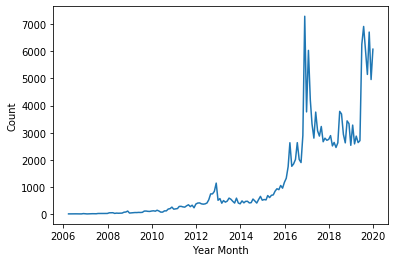

In [17]:
sns.lineplot(data=df_time, x='Year Month', y='Count')


## Grab All Submissions By Bad Actors

In [29]:
files = glob.glob('/shared/2/datasets/reddit-dump-all/RC/*.zst')
files.extend(glob.glob('/shared/2/datasets/reddit-dump-all/RC/*.xz'))
files.extend(glob.glob('/shared/2/datasets/reddit-dump-all/RC/*.bz2'))
files.extend(glob.glob('/shared/2/datasets/reddit-dump-all/RS/*.bz2'))
files.extend(glob.glob('/shared/2/datasets/reddit-dump-all/RS/*.xz'))
files[270]

'/shared/2/datasets/reddit-dump-all/RS/RS_v2_2010-03.xz'

In [ ]:
file = files[270]
print("Starting on file: {}".format(file))
extension = file.split('.')[-1]
if extension == "zst":
    user_politics = parse_zst_bad_actor_comments(file, bad_actors)
else:
    user_politics = parse_bad_actor_comments(file, bad_actors)

## How many submissions are there by political users?

# Bad Actors

In [46]:
year_month_ba_counts = Counter()

for user, political_data in bad_actors_constrained.items():
    first_pol_post_ts = int(political_data[0][1])
    first_post_date = datetime.fromtimestamp(first_pol_post_ts)
    year_month = str(first_post_date.year) + '-' + str(first_post_date.month)
    year_month_ba_counts[str(year_month)] += 1

# Convert to DF for seaborn
rows = []
for year_month, count in dict(year_month_ba_counts).items():
    row = {'Year Month': parser.parse(year_month), 'Count': int(count)}
    rows.append(row)
    
ba_time = pd.DataFrame(rows)
ba_time

,Year Month,Count
0,2019-05-28,89
1,2019-08-28,165
2,2016-11-28,372
3,2019-01-28,75
4,2012-08-28,32
...,...,...
144,2006-11-28,1
145,2008-02-28,1
146,2008-05-28,1
147,2009-10-28,1


Text(0.5, 1.0, 'Bad Actors Over Time')

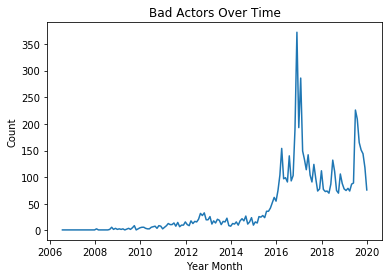

In [47]:
sns.lineplot(data=ba_time, x='Year Month', y='Count').set_title('Bad Actors Over Time')